In [1]:
# Install required packages
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:
#dotenv module
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
#Adding typing module for typed python
# Documentation for python typing annotation https://docs.python.org/3/library/typing.html
from typing import TypedDict, Annotated
import operator

In [4]:
#langgraph module and tavily search tool
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, HumanMessage
from langchain_tavily import TavilySearch

In [5]:
# Google Gemini used for this example : https://python.langchain.com/docs/integrations/providers/google/
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model

In [6]:
tool = TavilySearch(max_results=2)
print(type(tool))
print(tool.name)
print(vars(tool))
#response = tool.invoke("What is LangGraph?")
#print(response)

<class 'langchain_tavily.tavily_search.TavilySearch'>
tavily_search
{'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'args_schema': <class 'langchain_tavily.tavily_search.TavilySearchInput'>, 'return_direct': False, 'verbose': False, 'callbacks': None, 'callback_manager': None, 'tags': None, 'metadata': None, 'handle_tool_error': True, 'handle_validation_error': False, 'response_format': 'content', 'auto_parameters': None, 'include_domains': None, 'exclude_domains': None, 'search_depth': None, 'include_images': None, 'time_range': None, 'max_results': 2, 'topic': None, 'include_answer': None, 'include_raw_content': None, 

In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [8]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
       #self.model = model.bind_tools(tools)
        self.model = model

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}


In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = init_chat_model("google_genai:gemini-2.5-pro").bind_tools([tool])


abot = Agent(model, [tool], system=prompt)

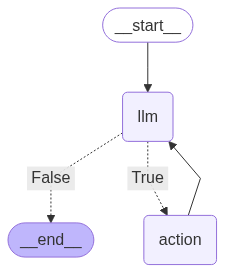

In [10]:

# We can easily display the graph we have created
from IPython.display import Image, display

display(Image(abot.graph.get_graph().draw_mermaid_png()))

In [11]:
messages = [HumanMessage(content = "What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search', 'args': {'query': 'weather in San Francisco'}, 'id': '82bf7b1f-8be8-4449-aab9-9d8cf3417d86', 'type': 'tool_call'}
Back to the model!


In [12]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "weather in San Francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--0036b2bb-10ab-4021-98bf-c807274433c3-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'weather in San Francisco'}, 'id': '82bf7b1f-8be8-4449-aab9-9d8cf3417d86', 'type': 'tool_call'}], usage_metadata={'input_tokens': 598, 'output_tokens': 20, 'total_tokens': 910, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 292}}),
  ToolMessage(content='{\'query\': \'weather in San Francisco\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in San Francisco\', \'url\': \'https://www.weather

In [13]:
result['messages'][-1].content

'The weather in San Francisco is partly cloudy with a temperature of 55.9°F. The wind is blowing from the southwest at 5.6 mph. The high for today is expected to be 64°F and the low is 59°F, with a 0% chance of precipitation.'

In [14]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search', 'args': {'query': 'weather in San Francisco'}, 'id': '6fc55fa1-a831-4f75-89f2-9294e9090381', 'type': 'tool_call'}
Calling: {'name': 'tavily_search', 'args': {'query': 'weather in Los Angeles'}, 'id': 'cb5610d2-339d-4d9b-9e50-54b1a0100f26', 'type': 'tool_call'}
Back to the model!


In [15]:
result['messages'][-1].content

'The weather in San Francisco is currently 55.9°F and partly cloudy. The forecast for today is a high of 64°F and a low of 59°F.\n\nIn Los Angeles, it is currently 64.0°F and overcast. The forecast for today is a high of 84°F and a low of 61°F.'